In [41]:
import pandas as pd
import numpy as np
from mapbox import Geocoder, Directions
import pickle
from shapely.geometry import Point, LineString
import time
import geopandas
import overpass
from shapely.geometry import LineString, Point
import config
import matplotlib.pyplot as plt

In [133]:
cols = [
    'aeroway',
    'amenity',
    'barrier',
    'boundary',
    'building',
    'healthcare',
    'highway',
    'landuse',
    'leisure',
    'man_made',
    'natural',
    'parking',
    'power',
    'railway',
    'route',
    'service',
    'surface',
    'tourism',
    'waterway'
]

def make_feature_dict(df, features, prefix=None):
    """
    
    Parameters
    ----------
    df : geopandas.geodataframe.GeoDataFrame
        Dataframe containing features pulled from overpass API
        
    features : list
        List of column names associated with high-level feature names
        employed by overpass/OSM. Reference here:
        https://wiki.openstreetmap.org/wiki/Map_Features
        
    prefix : str
        Additional identifier placed before feature name.
        
    Returns
    -------
    dict
        Nested dictionary of features with value counts as eventual values.
        
    """
    
    if prefix!=None:
        pass
    else:
        prefix=''
        
    feature_dict = {}
    for feature in features:
        if feature in df.columns:
            series = df[feature].value_counts()
            feature_dict[prefix+feature] = { k:v for (k,v) in zip(series.index, series.values)}
        else:
            feature_dict[prefix+feature] = None
    return feature_dict

In [103]:
def split_line(line, max_line_units=1*(0.07381197609536122)):
    """max_line_units=0.07381197609536122
    is set for 5 mile increments"""
    if line.length <= max_line_units:
        return [line]

    half_length = line.length / 2
    coords = list(line.coords)
    for idx, point in enumerate(coords):
        proj_dist = line.project(Point(point))
        if proj_dist == half_length:
            return [LineString(coords[:idx + 1]), LineString(coords[idx:])]

        if proj_dist > half_length:
            mid_point = line.interpolate(half_length)
            head_line = LineString(coords[:idx] + [(mid_point.x, mid_point.y)])
            tail_line = LineString([(mid_point.x, mid_point.y)] + coords[idx:])
            return split_line(head_line, max_line_units) + split_line(tail_line, max_line_units)

def overpass_query(line_list):
    # There is an index column here
    feature_df_list = [pd.read_csv('oh_deer/static/dummy_features.csv', index_col=0)]
    cols = feature_df_list[0].columns
    print("LINES:{}".format(len(line_list)))
    for n, line in enumerate(line_list):
        print("LINE:{}".format(n))
        poly = line.buffer(.0025, cap_style=3)
        simplified = poly.simplify(0.001, preserve_topology=False)
        
        # Building overpass queries
        road_query = 'nwr(around:1, {c[0]}, {c[1]});(._;>;);out;'.format(
            c=line.interpolate(0.5, normalized = True).coords[:][0])
        area_query = 'nwr(poly:"{}");out;'.format(
            ' '.join('{c[0]} {c[1]}'.format(c=c) for c in simplified.exterior.coords[:]))
        
        # Getting overpass road responses
        road_response = api_pass.get(road_query)
        road_geodf = geopandas.GeoDataFrame.from_features(road_response)
        culled_road = road_geodf.dropna(axis='index', how='all', subset=road_geodf.columns[1:])
        # Overwriting feature_dict each time
        feature_dict = make_feature_dict_road(culled_road, ['highway', 'surface'], prefix='road_')
        time.sleep(4)
        
        # Getting overpass area responses
        response = api_pass.get(area_query)
        geodf = geopandas.GeoDataFrame.from_features(response)
        culled_geodf = geodf.dropna(axis='index', how='all', subset=geodf.columns[1:])
        feature_dict.update(make_feature_dict_area(culled_geodf, cols, prefix=None))
        feature_df_list.append(pd.io.json.json_normalize(feature_dict))
        time.sleep(2)
    feature_df = pd.concat(feature_df_list, sort=True)
    feature_df.reset_index(inplace=True)
    return feature_df


def make_feature_dict_road(df, features, prefix=None):
    """
    
    Parameters
    ----------
    df : geopandas.geodataframe.GeoDataFrame
        Dataframe containing features pulled from overpass API
        
    features : list
        List of column names associated with high-level feature names
        employed by overpass/OSM. Reference here:
        https://wiki.openstreetmap.org/wiki/Map_Features
        
    prefix : str
        Additional identifier placed before feature name.
        
    Returns
    -------
    dict
        Nested dictionary of features with value counts as eventual values.
        
    """
    
    if prefix!=None:
        pass
    else:
        prefix=''
        
    feature_dict = {}
    for feature in features:
        if feature in df.columns:
            series = df[feature].value_counts()
            feature_dict[prefix+feature] = { k:v for (k,v) in zip(series.index, series.values)}
        #else:
            #feature_dict[prefix+feature] = None
    return feature_dict

def make_feature_dict_area(df, features, prefix=None):
    """
    
    Parameters
    ----------
    df : geopandas.geodataframe.GeoDataFrame
        Dataframe containing features pulled from overpass API
        
    features : list
        List of column names associated with high-level feature names
        employed by overpass/OSM. Reference here:
        https://wiki.openstreetmap.org/wiki/Map_Features
        
    prefix : str
        Additional identifier placed before feature name.
        
    Returns
    -------
    dict
        Nested dictionary of features with value counts as eventual values.
        
    """
    
    if prefix!=None:
        pass
    else:
        prefix=''
    feature_dict = {}
    for col in df.columns:
        col_prefix = prefix+col
        if col_prefix in features:
            series = df[col].value_counts()
            feature_dict[col_prefix] = { k:v for (k,v) in zip(series.index, series.values)}
        else:
            feature_dict[col_prefix] = None
        
    return feature_dict

In [156]:
model = pickle.load(open("pa_deer_pred.pickle.dat", "rb"))
api_pass = overpass.API(timeout=600)

dummy_df = pd.read_csv('dummy_features.csv', index_col=0)

In [157]:
dummy_df

,area_aeroway.aerodrome,area_aeroway.approach_light,area_aeroway.apron,area_aeroway.hangar,area_aeroway.helipad,area_aeroway.holding_position,area_aeroway.model_aerodrome,area_aeroway.parking_position,area_aeroway.runway,area_aeroway.taxiway,...,road_surface.metal_grate,road_surface.metal_grid,road_surface.paved,road_surface.paved+wood,road_surface.paving_stones,road_surface.stone,road_surface.underConstruction,road_surface.unimproved,road_surface.unpaved,road_surface.wood
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [73]:
# get origin and destination geolocations
key = config.mapbox['key']
geocoder = Geocoder()
geocoder.session.params['access_token'] = key
directions = Directions()
directions.session.params['access_token'] = key


startname = 'Pittsburgh, PA'
endname = 'Phyladelphia, PA'
if startname == '' or endname == '':
    startname = 'Pittsburgh, PA'
    endname = 'Philadelphia, PA'

startresponse = geocoder.forward(startname)
endresponse = geocoder.forward(endname)
origin = startresponse.geojson()['features'][0]
destination = endresponse.geojson()['features'][0]
response = directions.directions([origin, destination], 'mapbox/driving') 

coords = response.geojson()['features'][0]['geometry']['coordinates']
shapely_line = LineString(coords)
line = '['+','.join(["[{},{}]".format(lat, lon) for lat, lon in coords])+']'
# Splitting shapely_line
line_list = split_line(shapely_line)



In [161]:
#cols = feature_df_list[0].columns
feature_df_list = list()
print("LINES:{}".format(len(line_list)))
for n, line in enumerate(line_list[:]):
    print("LINE:{}".format(n))
    poly = line.buffer(.001, cap_style=3)
    simplified = poly.simplify(0.001, preserve_topology=False)

    # Building overpass queries
    midpoint = line.interpolate(0.5, normalized = True).coords[:][0]
    
    buffer = 5e-3
    road_query = 'nwr[highway]({}, {}, {}, {});(._;>;);out;'.format(midpoint[1]-buffer, midpoint[0]-buffer, midpoint[1]+buffer, midpoint[0]+buffer)
    area_query = 'nwr(poly:"{}");out;'.format(
        ' '.join('{c[1]} {c[0]}'.format(c=c) for c in simplified.exterior.coords[:]))

    # Getting overpass road responses
    road_response = api_pass.get(road_query)
    road_geodf = geopandas.GeoDataFrame.from_features(road_response)
    culled_road = road_geodf.dropna(axis='index', how='all', subset=road_geodf.columns[1:])
    # Overwriting feature_dict each time
    feature_dict = make_feature_dict(culled_road, ['highway', 'surface'], prefix='road_')
    #feature_dict = make_feature_dict_road(culled_road, ['highway', 'surface'], prefix='road_')
    time.sleep(0)

    # Getting overpass area responses
    response = api_pass.get(area_query)
    geodf = geopandas.GeoDataFrame.from_features(response)
    culled_geodf = geodf.dropna(axis='index', how='all', subset=geodf.columns[1:])
    feature_dict.update(make_feature_dict(culled_geodf, cols, prefix='area_'))
    #feature_dict.update(make_feature_dict_area(culled_geodf, cols, prefix=None))
    feature_df_list.append(pd.io.json.json_normalize(feature_dict))
    time.sleep(0)


LINES:8
LINE:0
LINE:1
LINE:2
LINE:3
LINE:4
LINE:5
LINE:6


ConnectionError: ('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer'))

In [185]:
line.interpolate(0.5, normalized=True).coords[:][0]

(-76.04655999063803, 40.2143929011437)

In [170]:
feature_df.shape

(6, 198)

In [171]:
feature_df = pd.concat(feature_df_list, ignore_index=True, sort=False)
feature_df = pd.concat([dummy_df, feature_df], sort=False)[dummy_df.columns].iloc[1:,:]

In [172]:
feature_df

,area_aeroway.aerodrome,area_aeroway.approach_light,area_aeroway.apron,area_aeroway.hangar,area_aeroway.helipad,area_aeroway.holding_position,area_aeroway.model_aerodrome,area_aeroway.parking_position,area_aeroway.runway,area_aeroway.taxiway,...,road_surface.metal_grate,road_surface.metal_grid,road_surface.paved,road_surface.paved+wood,road_surface.paving_stones,road_surface.stone,road_surface.underConstruction,road_surface.unimproved,road_surface.unpaved,road_surface.wood
0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [173]:
y_pred = model.predict(feature_df)

In [174]:
y_pred

array([0.28593183, 0.39942867, 0.45605472, 0.42047325, 0.40229756,
       0.31885308], dtype=float32)

In [147]:
dummy_df.shap

(1, 817)

In [136]:
culled_geodf.shape

(444, 103)

In [137]:
culled_road.shape

(20, 29)

In [144]:
for col in feature_df.columns:
    if col in dummy_df.columns:
        print('yes, {}'.format(col))
    else:
        print('no, {}'.format(col))

no, road_surface
no, area_aeroway
no, area_healthcare
no, area_leisure
no, area_parking
no, area_route
no, area_tourism
yes, road_highway.emergency_bay
yes, road_highway.motorway
yes, road_highway.motorway_junction
yes, road_highway.tertiary
yes, road_highway.residential
yes, area_amenity.school
yes, area_amenity.restaurant
yes, area_barrier.toll_booth
yes, area_barrier.gate
yes, area_boundary.administrative
yes, area_building.office
yes, area_building.roof
yes, area_highway.motorway
yes, area_highway.service
yes, area_highway.motorway_link
yes, area_highway.residential
yes, area_highway.secondary
yes, area_highway.unclassified
yes, area_highway.tertiary
yes, area_highway.cycleway
yes, area_highway.track
yes, area_highway.motorway_junction
yes, area_highway.trunk
yes, area_highway.primary
yes, area_highway.emergency_bay
yes, area_highway.stop
yes, area_highway.footway
yes, area_highway.services
yes, area_landuse.forest
yes, area_landuse.cemetery
yes, area_landuse.industrial
yes, area_m

(array([1066.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         103.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

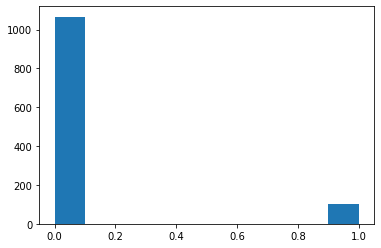

In [45]:
plt.hist(feature_df.count())

In [46]:
geodf.shape

(4246, 102)

In [47]:
culled_geodf.shape

(476, 102)

In [52]:
for col in culled_geodf.columns:
    if col in cols:
        print(col)

highway
amenity
landuse
building
power
man_made
surface
barrier
railway
service
natural
tourism
waterway
boundary
leisure
parking


In [54]:
for col in road_geodf.columns:
    if col in cols:
        print(col)

In [ ]:
line = line_list[0]
poly = line.geometry.buffer(.0025, cap_style=3)
simplified = poly.simplify(0.001, preserve_topology=False)

# Building overpass queries
road_query = 'nwr(around:1, {c[0]}, {c[1]});(._;>;);out;'.format(
    c=line.geometry.interpolate(0.5, normalized = True).coords[:][0])
area_query = 'nwr(poly:"{}");out;'.format(
    ' '.join('{c[0]} {c[1]}'.format(c=c) for c in simplified.exterior.coords[:]))

# Getting overpass road responses
road_response = api_pass.get(road_query)
road_geodf = geopandas.GeoDataFrame.from_features(road_response)
culled_road = road_geodf.dropna(axis='index', how='all', subset=road_geodf.columns[1:])
# Overwriting feature_dict each time
feature_dict = make_feature_dict(culled_road, ['highway', 'surface'], prefix='road_')
time.sleep(1)

# Getting overpass area responses
response = api_pass.get(area_query)
geodf = geopandas.GeoDataFrame.from_features(response)
culled_geodf = geodf.dropna(axis='index', how='all', subset=geodf.columns[1:])
feature_dict.update(make_feature_dict(culled_geodf, cols, prefix='area_'))
feature_df_list.append(pd.io.json.json_normalize(feature_dict))
time.sleep(1)

In [62]:
test_line = line_list[0]

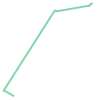

In [63]:
test_line

In [61]:
from mapboxgl.viz import *
from mapboxgl.utils import *
token = 'pk.eyJ1IjoiZGF0YXNsZXV0aCIsImEiOiJjazB0em1tbGUwaXdnM21yenJjdTJybm52In0.qm4lOhweUJZuaxgEl6lEwA'

In [21]:
#temp = df_collisions.dropna(axis='rows', subset=['lat', 'lon'], how='any')[['lat', 'lon']]
#geojson = df_to_geojson(temp, lat='lat', lon='lon', precision=10)

In [68]:
geojson

{'type': 'FeatureCollection',
 'features': [{'id': '0',
   'type': 'Feature',
   'properties': {},
   'geometry': {'type': 'LineString',
    'coordinates': ((-79.99014, 40.44168),
     (-79.99087, 40.44274),
     (-79.99221, 40.4428),
     (-79.9941, 40.44186),
     (-79.9942, 40.44187),
     (-79.99492, 40.44213),
     (-79.9992, 40.43609),
     (-80.00158, 40.43687),
     (-80.09357, 40.42078),
     (-80.09863, 40.4228),
     (-80.10472, 40.41468),
     (-80.24736, 40.19094),
     (-80.23978, 40.18749),
     (-80.21713380666266, 40.17440670036892))},
   'bbox': (-80.24736, 40.17440670036892, -79.99014, 40.4428)}],
 'bbox': (-80.24736, 40.17440670036892, -79.99014, 40.4428)}

In [79]:
geojson = geopandas.GeoSeries(line_list).__geo_interface__
viz = LinestringViz(geojson, access_token=token, 
                    center = (-80.00158, 40.4368), 
                    zoom = 7,
                    below_layer='waterway-label')
viz.show()